# Quick Start with AAanalysis
Dive into the powerful capabilities of ``AAanalysis``—a Python framework dedicated to sequence-based, alignment-free protein prediction. In this tutorial, using gamma-secretase substrates and non-substrates as an example, we'll focus on extracting interpretable features from protein sequences using the ``AAclust`` and ``CPP`` models and how they can be harnessed for binary classification tasks.

## What You Will Learn:

- ``Loading Sequences and Scales``: How to easily load protein sequences and their amino acid scales.
- ``Feature Engineering``: Extract essential features using the ``AAclust`` and ``CPP`` models.
- ``Protein Prediction``: Make predictions using the RandomForest model.
- ``Explainable AI``: Interpret predictions at the group and individual levels by combining ``CPP`` with ``SHAP``.

## 1. Loading Sequences and Scales
With AAanalysis, you have access to numerous benchmark datasets for protein sequence analysis. Using our γ-secretase substrates and non-substrates dataset as a hands-on example, you can effortlessly retrieve these datasets using the ``aa.load_dataset()`` function. Furthermore, amino acid scales, predominantly from AAindex, along with their hierarchical classification (known as ``AAontology``), are available at your fingertips with the ``aa.load_scales()`` function.

In [11]:
import aaanalysis as aa

df_scales = aa.load_scales()
df_seq = aa.load_dataset(name="DOM_GSEC", n=50)
df_seq.head(5)

,entry,sequence,label,tmd_start,tmd_stop,jmd_n,tmd,jmd_c
0,Q14802,MQKVTLGLLVFLAGFPVLDANDLEDKNSPFYYDWHSLQVGGLICAG...,0,37,59,NSPFYYDWHS,LQVGGLICAGVLCAMGIIIVMSA,KCKCKFGQKS
1,Q86UE4,MAARSWQDELAQQAEEGSARLREMLSVGLGFLRTELGLDLGLEPKR...,0,50,72,LGLEPKRYPG,WVILVGTGALGLLLLFLLGYGWA,AACAGARKKR
2,Q969W9,MHRLMGVNSTAAAAAGQPNVSCTCNCKRSLFQSMEITELEFVQIII...,0,41,63,FQSMEITELE,FVQIIIIVVVMMVMVVVITCLLS,HYKLSARSFI
3,P53801,MAPGVARGPTPYWRLRLGGAALLLLLIPVAAAQEPPGAACSQNTNK...,0,97,119,RWGVCWVNFE,ALIITMSVVGGTLLLGIAICCCC,CCRRKRSRKP
4,Q8IUW5,MAPRALPGSAVLAAAVFVGGAVSSPLVAPDNGSSRTLHSRTETTPS...,0,59,81,NDTGNGHPEY,IAYALVPVFFIMGLFGVLICHLL,KKKGYRCTTE


## 2.  Feature Engineering
The centerpiece of AAanalysis is the Comparative Physicochemical Profiling (``CPP``) model, which is supported by ``AAclust`` for the pre-selection of amino acid scales. 

### AAclust
Since redundancy is an essential problem for machine learning tasks, the ``AAclust`` object provides a lightweight wrapper for sklearn clustering algorithms such as Agglomerative clustering. AAclust clusters a set of scales and selects for each cluster the most representative scale (i.e., the scale closes to the cluster center). We will use AAclust to obtain a set of 100 scales, as defined by the ``n_clusters`` parameters:

In [12]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

aac = aa.AAclust(model=AgglomerativeClustering)
X = np.array(df_scales)
scales = aac.fit(X, names=list(df_scales), n_clusters=100) 
df_scales = df_scales[scales]
df_scales[scales[0:4]].head(5)

,ANDN920101,SIMZ760101,NAKH900106,AURR980112
AA,,,,
A,0.494,0.268,0.237,0.787
C,0.864,0.258,0.303,0.104
D,1.000,0.206,0.000,0.451
E,0.420,0.210,0.090,0.823
F,0.877,0.887,0.724,0.402


### Comparative Physicochemical Profiling (CPP)
 CPP is a sequence-based feature engineering algorithm. It aims at identifying a set of features most discriminant between two sets of sequences: the test set and the reference set. Supported by the ``SequenceFeature`` object (``sf``), A CPP feature integrates:
- ``Parts``: Are combination of a target middle domain (TMD) and N- and C-terminal adjacent regions (JMD-N and JMD-C, respectively), obtained ``sf.get_df_parts``.
- ``Splits``: These `Parts` can be split into various continuous segments or discontinuous patterns, specified ``sf.get_split_kws()``. 
- ``Scales``: Sets of amino acid scales.

We use SequenceFeature to obtain Parts and Splits:

In [13]:
y = list(df_seq["label"])
sf = aa.SequenceFeature()
df_parts = sf.get_df_parts(df_seq=df_seq, list_parts=["tmd_jmd"])
split_kws = sf.get_split_kws(n_split_max=1, split_types=["Segment"])
df_parts.head(5)

,tmd_jmd
D3ZZK3,RIIGDGANSTVLLVSVSGSVVLVVILIAAFVISRRRSKYSQAK
O14786,PGNVLKTLDPILITIIAMSALGVLLGAVCGVVLYCACWHNGMS
O35516,SELESPRNAQLLYLLAVAVVIILFFILLGVIMAKRKRKHGFLW
O43914,DCSCSTVSPGVLAGIVMGDLVLTVLIALAVYFLGRLVPRGRGA
O75581,YPTEEPAPQATNTVGSVIGVIVTIFVSGTVYFICQRMLCPRMK


Running the CPP algorithm creates all `Part`, `Split`, `Split` combinations and filters a selected maximum of non-redundant features. As a baseline approach,
we use CPP to compute the average values for the 100 selected scales over the entire TMD-JMD sequences:

In [14]:
# Small set of CPP features (100 features are created)
cpp = aa.CPP(df_scales=df_scales, df_parts=df_parts, split_kws=split_kws, verbose=False)
df_feat = cpp.run(labels=y) 
df_feat

,feature,category,subcategory,scale_name,scale_description,abs_auc,abs_mean_dif,mean_dif,std_test,std_ref,p_val_mann_whitney,p_val_fdr_bh,positions
0,"TMD_JMD-Segment(1,1)-ANDN920101",Structure-Activity,Backbone-dynamics (-CH),α-CH chemical shifts (backbone-dynamics),"alpha-CH chemical shifts (Andersen et al., 1992)",0.130,0.022966,0.022966,0.054433,0.053266,0.025737,0.099022,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
1,"TMD_JMD-Segment(1,1)-VASM830101",Conformation,Unclassified (Conformation),α-helix,Relative population of conformational state A ...,0.120,0.019298,-0.019298,0.046755,0.049127,0.039609,0.099022,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
2,"TMD_JMD-Segment(1,1)-ROBB760113",Conformation,β-turn,β-turn,"Information measure for loop (Robson-Suzuki, 1...",0.108,0.021958,0.021958,0.060658,0.053190,0.062212,0.100670,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
3,"TMD_JMD-Segment(1,1)-RACS820103",Conformation,Unclassified (Conformation),α-helix (left-handed),Average relative fractional occurrence in AL(i...,0.080,0.019579,-0.019579,0.072260,0.047452,0.166907,0.166907,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."


## 3. Protein Prediction
A feature matrix from a given set of CPP features can be created using ``sf.feat_matrix`` and used for machine learning:

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = sf.feat_matrix(df_parts=df_parts, features=df_feat["feature"])
rf = RandomForestClassifier()
cv_base = cross_val_score(rf, X, y, scoring="accuracy")
print(f"Mean accuracy of {round(np.mean(cv_base), 2)}")

Mean accuracy of 0.58


Creating more features with CPP will take some more time. but improve prediction performance: 

In [16]:
# CPP features with default splits (around 100.000 features)
df_parts = sf.get_df_parts(df_seq=df_seq)
cpp = aa.CPP(df_scales=df_scales, df_parts=df_parts, verbose=False)
df_feat = cpp.run(labels=y)
df_feat.head(10)

,feature,category,subcategory,scale_name,scale_description,abs_auc,abs_mean_dif,mean_dif,std_test,std_ref,p_val_mann_whitney,p_val_fdr_bh,positions
0,"TMD_C_JMD_C-Segment(2,3)-QIAN880106",Conformation,α-helix,α-helix (middle),Weights for alpha-helix at the window position...,0.387,0.121446,0.121446,0.069196,0.085013,0.000000e+00,0.000000e+00,"27,28,29,30,31,32,33"
1,"TMD_C_JMD_C-Segment(4,5)-ZIMJ680104",Energy,Isoelectric point,Isoelectric point,"Isoelectric point (Zimmerman et al., 1968)",0.373,0.220000,0.220000,0.123716,0.137350,1.000000e-10,2.475000e-07,"33,34,35,36"
2,"TMD_C_JMD_C-Pattern(N,5,8,12,15)-QIAN880106",Conformation,α-helix,α-helix (middle),Weights for alpha-helix at the window position...,0.358,0.144860,0.144860,0.079321,0.117515,7.000000e-10,7.150000e-07,"25,28,32,35"
3,"TMD_C_JMD_C-Segment(5,7)-LINS030101",ASA/Volume,Volume,Accessible surface area (ASA),Total accessible surfaces of whole residues (b...,0.354,0.237161,0.237161,0.145884,0.164285,1.100000e-09,7.150000e-07,"32,33,34"
4,"TMD_C_JMD_C-Segment(6,9)-ZIMJ680104",Energy,Isoelectric point,Isoelectric point,"Isoelectric point (Zimmerman et al., 1968)",0.341,0.263651,0.263651,0.187136,0.171995,4.000000e-09,1.185395e-06,"32,33"
5,"TMD_C_JMD_C-Segment(4,9)-ROBB760113",Conformation,β-turn,β-turn,"Information measure for loop (Robson-Suzuki, 1...",0.337,0.319440,-0.319440,0.175203,0.255754,6.100000e-09,1.185395e-06,"27,28"
6,"TMD_C_JMD_C-Segment(2,2)-EISD860102",Energy,Isoelectric point,Atom-based hydrophobic moment,Atom-based hydrophobic moment (Eisenberg-McLac...,0.337,0.139567,0.139567,0.098917,0.101842,6.300000e-09,1.185395e-06,"31,32,33,34,35,36,37,38,39,40"
7,"TMD_C_JMD_C-Segment(4,5)-RICJ880113",Conformation,α-helix (C-cap),"α-helix (C-terminal, inside)",Relative preference value at C2 (Richardson-Ri...,0.336,0.223765,0.223765,0.133513,0.178217,7.100000e-09,1.185395e-06,"33,34,35,36"
8,"TMD_C_JMD_C-Segment(5,7)-KARS160107",Shape,Side chain length,Eccentricity (maximum),Diameter (maximum eccentricity) (Karkbara-Knis...,0.331,0.217594,0.217594,0.136011,0.172395,1.130000e-08,1.331786e-06,"32,33,34"
9,"TMD_C_JMD_C-Pattern(C,4,8)-JURD980101",Polarity,Hydrophobicity,Hydrophobicity,Modified Kyte-Doolittle hydrophobicity scale (...,0.329,0.264720,-0.264720,0.141666,0.233134,1.480000e-08,1.425259e-06,"33,37"


Which can be again used for machine learning:

Mean accuracy of 0.9


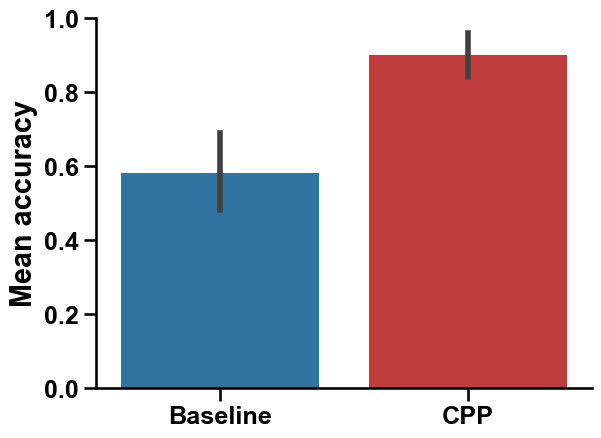

In [18]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pandas as pd

X = sf.feat_matrix(df_parts=df_parts, features=df_feat["feature"])
rf = RandomForestClassifier()
cv = cross_val_score(rf, X, y, scoring="accuracy", cv=5, n_jobs=1) 
print(f"Mean accuracy of {round(np.mean(cv), 2)}")

aa.plot_settings(font_scale=1.1)
sns.barplot(pd.DataFrame({"Baseline": cv_base, "CPP": cv}), palette=["tab:blue", "tab:red"])
plt.ylabel("Mean accuracy", size=aa.plot_gcfs()+1)
plt.ylim(0, 1)
sns.despine()
plt.show()

## 4. Explainable AI

### Explainable AI on group level

### Explainable AI on individual level